<a href="https://colab.research.google.com/github/komh9575/first-repository/blob/main/Part3_Churn_Prediction_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%8B%E1%85%AD%E1%86%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: 고객 이탈 예측 (Churn Prediction)

## 🔄 지난 실습 요약 및 새로운 미션

### 1️⃣ Part 1 & 2 요약: 우리는 고객을 '나누기'만 했습니다
지난 시간까지 우리는 **RFM 분석**과 **K-Means 클러스터링**을 통해 고객을 세가지 그룹(등급)으로 나누었습니다.
- **VIP (Gold)**: 우리 매출을 책임지는 고마운 분들
- **일반 (Silver)**: 잠재력이 있는 중간층
- **이탈 위험 (Bronze)**: 구매가 뜸하고 관리가 필요한 그룹

### 2️⃣ 문제점 발견: "등급만으로는 부족하다!"
팀장이 이런 질문을 던졌습니다.
> **"Bronze 등급이라고 다 떠나는 건 아니잖아요? 개중에 누가 '다음 달'에 진짜로 떠날지 콕 집어주세요!"**

맞습니다. 단순히 "등급이 낮다"는 것과 "미래에 이탈한다"는 것은 다릅니다.
VIP 고객이라도 갑자기 불만을 품고 떠날 수 있고, Bronze 고객이라도 꾸준히 구매할 수 있습니다.

### 3️⃣ 우리의 미션: "진짜 이탈자를 예측하라"
이제 우리는 단순한 **분류(Segmentation)**를 넘어 **예측(Prediction)**의 단계로 나아갑니다.
**과거의 행동 데이터**를 학습하여, **미래의 이탈 여부**를 정확히 맞추는 머신러닝 모델을 만들어봅시다.

---

## 🎯 학습 목표
1. **Time-Window Split**: 과거(1-9월) 데이터로 미래(10-12월)를 예측하는 실무 기법 익히기
2. **Advanced Modeling**: **XGBoost**를 활용하여 이탈 확률을 정밀하게 계산하기
3. **Actionable Insight**: **SHAP**을 통해 "이 고객이 왜 떠나려 하는지" 이유 찾아내기

In [ ]:
# !pip install xgboost shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 & 시각화
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import shap

%matplotlib inline
print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


## 1. 데이터 로드 및 전처리
- **주의**: 이 실습은 Raw Transaction Data(`Online Retail.xlsx`)가 필요합니다.
- `rfm.csv` 같은 요약 데이터가 아닌, **날짜별 거래 내역**이 있어야 Time-Split이 가능합니다.

In [ ]:
# TODO: 데이터 로드하기
# 힌트: pd.read_excel() 함수를 사용하여 'Final/data/Online Retail.xlsx' 경로의 데이터를 로드하세요
# 경로는 본인의 환경에 맞게 수정이 필요할 수 있습니다
# 로드 후 df.head()로 상위 5개 행을 확인해보세요
df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# TODO: 데이터 타입 확인하기
# 힌트: df.dtypes를 사용하여 각 컬럼의 데이터 타입을 확인하세요
# 특히 InvoiceDate 컬럼의 타입을 확인해보세요
df.dtypes


,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


In [ ]:
# TODO: 날짜 형식 변환하기
# 힌트: InvoiceDate 컬럼을 datetime 형식으로 변환하세요
# pd.to_datetime() 함수를 사용하면 됩니다
# 변환 후 df.dtypes로 다시 확인해보세요
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


In [ ]:
# TODO: 데이터 전처리 수행하기
# 1. 반품 데이터 제외: Quantity가 0보다 큰 데이터만 남기세요 (힌트: boolean indexing 사용)
# 2. 총 매출 생성: Quantity * UnitPrice를 계산하여 TotalPrice 컬럼을 생성하세요
# 힌트: df[조건]으로 필터링하고, df['새컬럼'] = 계산식으로 컬럼을 추가할 수 있습니다
df=df[df['Quantity']>0]
df['TotalPrice']=df['Quantity']*df['UnitPrice']

In [ ]:
from IPython.utils.text import string
# TODO: 전체 데이터의 기간과 총 거래 건수 출력하기
# 힌트: InvoiceDate의 min(), max()로 기간을 확인하고, len(df)로 건수를 확인하세요
# f-string을 사용하여 출력 형식을 맞춰보세요
InvoiceDate_min=df['InvoiceDate'].min()
InvoiceDate_max=df['InvoiceDate'].max()
date_range_string=f"데이터 기간: {InvoiceDate_min} ~ {InvoiceDate_max}"
print(date_range_string)
print(f"총 거래건수: len(df)")

데이터 기간: 2010-12-01 08:26:00 ~ 2011-12-09 12:50:00
총 거래건수: len(df)


## 2. Time-Window Splitting
- **기준일(Cutoff Date)**: 데이터의 약 75% 지점 (예: `2011-09-30`)
- 이 날짜 이전 데이터로 **모델 학습(Feature)**, 이후 데이터로 **정답(Label)** 생성

In [ ]:
# TODO: 기준일 확인하기
# 힌트: quantile(0.75)를 사용하여 전체 거래 날짜 중 하위 75%에 해당하는 날짜를 확인하세요
# 이 값이 우리가 사용할 cutoff_date의 근사치입니다
cutoff_date=df['InvoiceDate'].quantile(0.75)
print(cutoff_date)

2011-10-19 12:35:00


In [ ]:
# TODO: 기준일(Cutoff Date) 설정하기
# 힌트: pd.to_datetime()을 사용하여 '2011-09-30'을 datetime 형식으로 변환하세요
# 이 날짜를 기준으로 데이터를 나눌 것입니다
cutoff_date=pd.to_datetime('2011-09-30')
cutoff_date

Timestamp('2011-09-30 00:00:00')

In [ ]:
# TODO: 데이터 분할하기
# 1. train_df: cutoff_date 이전(이하) 데이터를 필터링하세요 (관찰 기간, Feature 생성용)
# 2. test_df: cutoff_date 이후 데이터를 필터링하세요 (성과 기간, Label 생성용)
# 힌트: boolean indexing을 사용하세요 (df[df['컬럼'] <= 값] 또는 df[df['컬럼'] > 값])
# 분할 후 각 데이터프레임의 길이를 출력하여 확인하세요
train_df=df[df['InvoiceDate']<= cutoff_date]
test_df=df[df['InvoiceDate']> cutoff_date]
print(f"feature 생성 기간: {cutoff_date} 데이터수: {len(train_df)}")
print(f"Target 확인 기간: {cutoff_date} 데이터수: {len(test_df)}")


feature 생성 기간: 2011-09-30 00:00:00 데이터수: 361413
Target 확인 기간: 2011-09-30 00:00:00 데이터수: 169872


## 3. Feature Engineering & Labeling
1. **Features**: 9월 30일 시점에서의 RFM + $\alpha$ (평균 객단가, 구매 주기 등)
2. **Label**: 10월 이후 구매 기록이 없으면 `1` (이탈), 있으면 `0` (생존)

In [ ]:
# TODO: Feature 생성하기 (관찰 기간 데이터 기반)
# CustomerID별로 다음 RFM 지표를 계산하세요:
# 1. Recency: cutoff_date와 마지막 구매일(InvoiceDate.max())의 차이 (일 단위)
# 2. Frequency: 구매 횟수 (InvoiceNo의 count)
# 3. Monetary_Sum: 총 구매액 (TotalPrice의 sum)
# 4. Monetary_Avg: 평균 구매액 (TotalPrice의 mean)

features = train_df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (cutoff_date - x.max()).days),
    Frequency=('InvoiceNo', 'count'),
    Monetary_Sum=('TotalPrice', 'sum'),
    Monetary_Avg=('TotalPrice', 'mean')
)
features.head()

,Recency,Frequency,Monetary_Sum,Monetary_Avg
CustomerID,,,,
12346.0,254,1,77183.60,77183.600000
12347.0,58,124,2790.86,22.506935
12348.0,4,31,1797.24,57.975484
12350.0,239,17,334.40,19.670588
12352.0,1,70,2194.31,31.347286


In [ ]:
# TODO: 컬럼명 변경하기
# 힌트: features.columns에 리스트를 할당하여 컬럼명을 변경하세요
# 순서: ['Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Avg']
features.columns=['Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Avg']


In [ ]:
# TODO: Label 생성하기 (성과 기간 데이터 기반)
# 1. 성과 기간(test_df)에 구매한 고객 ID 목록을 추출하세요 (힌트: unique() 사용)
active_customers = test_df['CustomerID'].unique()
# 2. features의 각 고객이 이 목록에 있는지 확인하세요 (힌트: isin() 사용)
# 3. Label 규칙:
#    - 성과 기간에 구매한 고객 (active_customers에 포함) -> 0 (생존)
#    - 성과 기간에 구매하지 않은 고객 (포함되지 않음) -> 1 (이탈)
# 힌트: isin()의 결과를 반전시켜야 합니다 (구매함=0, 구매안함=1)
# 힌트: apply(lambda x: 0 if x == 1 else 1) 또는 1 - isin() 결과를 사용할 수 있습니다
features['churn'] = (~features.index.isin(active_customers)).astype(int)
features.head()
features['churn'].value_counts(1)

,proportion
churn,
0,0.512209
1,0.487791


### 3-1. 데이터 탐색 (EDA)
- 이탈 고객과 생존 고객의 RFM 분포 차이 확인

In [ ]:
# TODO: 이탈 고객과 생존 고객의 RFM 지표 평균 비교하기
# 힌트: groupby('Churn').mean()을 사용하여 Churn 값(0 또는 1)별로 평균을 계산하세요
# 어떤 차이가 보이나요? Recency, Frequency, Monetary 값의 차이를 분석해보세요
features.groupby('churn').mean()

,Recency,Frequency,Monetary_Sum,Monetary_Avg
churn,,,,
0,66.819610,109.115926,2590.666214,29.576556
1,118.477247,36.198521,779.110167,92.176701


## 4. 모델링 (XGBoost)
- **불균형 처리**: `scale_pos_weight` 파라미터 활용 (이탈자보다 생존자가 많거나 그 반대의 경우 보정)
- **Train/Test Split**: 여기서는 모델 성능 검증을 위해 고객 단위로 Random Split 진행

### 💡 잠깐! 핵심 개념 짚고 넘어가기

#### 1. XGBoost (Extreme Gradient Boosting)
- **"오답 노트의 달인"**: 여러 개의 모델이 순차적으로 학습하며, **이전 모델이 틀린 문제(데이터)를 다음 모델이 집중적으로 공부**하는 방식(Boosting)입니다.
- 속도가 빠르고 성능이 강력하여 실무와 대회에서 가장 많이 쓰이는 모델 중 하나입니다.

#### 2. 불균형 데이터 처리 (`scale_pos_weight`)
- **문제 상황**: 이탈자(1)보다 생존자(0)가 훨씬 많은 경우, 모델은 "그냥 다 생존자라고 찍자!"라고 꾀를 부릴 수 있습니다 (정확도 95%의 함정).
- **해결책**: 소수 클래스인 **이탈자(1)를 틀렸을 때 더 큰 벌점(가중치)**을 줍니다.
- **공식**: `(생존자 수) / (이탈자 수)` 비율만큼 가중치를 부여하여 균형을 맞춥니다.

In [ ]:
!pip install xgboost shap

In [ ]:
# TODO: XGBoost 모델 학습하기
# 1. X, y 분리: features에서 'Churn' 컬럼을 제외한 나머지를 X로, 'Churn'을 y로 설정하세요
# 2. Train/Test Split: train_test_split을 사용하여 80:20으로 분할하세요 (random_state=42)
# 3. 불균형 비율 계산: scale_pos_weight = (음성 클래스 수) / (양성 클래스 수)
#    힌트: np.sum(y_train == 0) / np.sum(y_train == 1)
# 4. XGBClassifier 모델 생성 및 학습:
#    - n_estimators=100, learning_rate=0.05, max_depth=5
#    - scale_pos_weight=ratio (위에서 계산한 값)
#    - random_state=42, use_label_encoder=False, eval_metric='logloss'
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# X, y 분리
X = features.drop('churn', axis=1)
y = features['churn']

#학습/테스트 분리(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ratio = float(np.sum(y_train == 0) / np.sum(y_train == 1))

#모델학습
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=ratio,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

## 5. 모델 평가 및 해석 (XAI)
- 단순 Accuracy보다는 Precision(정밀도)와 Recall(재현율) 확인
- **SHAP Value**: 모델이 왜 특정 고객을 이탈로 예측했는지 원인 분석

### 🔍 SHAP (SHapley Additive exPlanations)이란?
- **"블랙박스 모델의 통역사"**: XGBoost처럼 속을 알 수 없는 모델이 **"왜" 그런 예측을 했는지 설명해 주는 도구**입니다.
- 게임 이론(Game Theory)을 바탕으로, 각 Feature(예: Recency)가 예측 결과(이탈 확률)에 얼마나 기여했는지 점수로 계산합니다.

#### 📊 시각화 해석 방법 (Summary Plot)
1. **X축 (SHAP Value)**:
   - **오른쪽(+)**: 이탈 확률을 **높이는** 요인
   - **왼쪽(-)**: 이탈 확률을 **낮추는(생존)** 요인
2. **색상 (Feature Value)**:
   - **빨간색**: 해당 Feature의 값이 **높음** (High)
   - **파란색**: 해당 Feature의 값이 **낮음** (Low)

> **예시**: `Recency` 점들이 **빨간색(값이 큼)**일 때 **오른쪽(이탈 확률 ↑)**에 몰려 있다면?
> 👉 **"최근 구매일이 오래될수록(Recency가 클수록) 이탈할 확률이 높아진다"**라고 해석할 수 있습니다.

In [ ]:
# TODO: 모델 예측 및 평가하기
# 1. 예측 수행:
#    - y_pred: 이탈 여부 예측 (0 또는 1) - model.predict() 사용
#    - y_prob: 이탈 확률 예측 (0~1 사이 값) - model.predict_proba() 사용, [:, 1]로 양성 클래스 확률 추출
# 2. 평가 리포트 출력:
#    - classification_report(y_test, y_pred)로 Precision, Recall, F1-score 확인
#    - roc_auc_score(y_test, y_prob)로 ROC-AUC 점수 확인
# 힌트: ROC-AUC는 0.5에 가까울수록 성능이 낮고, 1에 가까울수록 성능이 좋습니다

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.70      0.70      0.70       379
           1       0.67      0.67      0.67       342

    accuracy                           0.69       721
   macro avg       0.69      0.69      0.69       721
weighted avg       0.69      0.69      0.69       721

0.750536190961132


In [ ]:
# TODO: SHAP Value를 사용한 모델 해석하기
# 1. SHAP Explainer 생성: shap.TreeExplainer(model) 사용
# 2. SHAP Value 계산: explainer.shap_values(X_test)
# 3. 시각화:
#    - Summary Plot (Bar): shap.summary_plot(shap_values, X_test, plot_type="bar")
#      -> 각 feature의 평균적인 중요도를 막대 그래프로 확인
#    - Summary Plot (Bee-swarm): shap.summary_plot(shap_values, X_test)
#      -> 각 샘플별로 feature가 예측에 미친 영향을 확인
# 힌트: plt.figure(figsize=(10, 6))로 그래프 크기를 설정할 수 있습니다
# 어떤 feature가 이탈 예측에 가장 큰 영향을 미치나요?

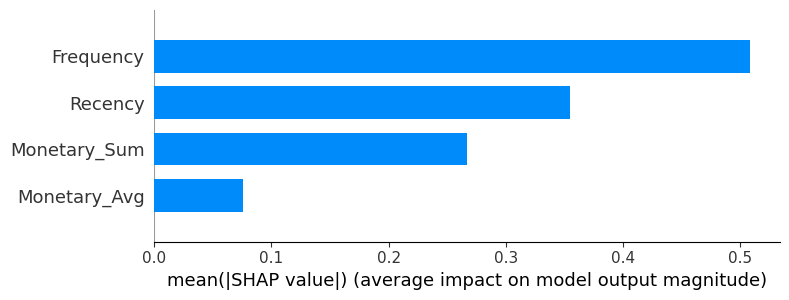

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

## 🎯 결론 및 활용 방안
1. **주요 이탈 요인**: SHAP 결과를 통해 `Recency`가 클수록, `Frequency`가 낮을수록 이탈 위험이 높음을 통계적으로 확인
2. **타겟팅**: 이탈 확률(Probability) 상위 10% 고객 추출 -> 쿠폰 발송 등 리텐션 마케팅 실행
3. **비즈니스 임팩트**: 랜덤 타겟팅 대비 모델 기반 타겟팅의 **Lift Score**를 산출하여 ROI 증명 가능